![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#librerias
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
# Celda 1
def funcion_costo(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    Error_Left= np.sum((y_l.mean()-y_l)**2)/y_l.shape[0] #Error cuadratico Left
    Error_Right=np.sum((y_r.mean()-y_r)**2)/y_r.shape[0] # Error cuadratico Right
    Cost_F = (Error_Left * y_l.shape[0]) + (Error_Right * y_r.shape[0]) 
    Cost_F
    return Cost_F
    
#Mejor división
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 999999999999999999999]  # j, split, cost_function
    
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            fcost = funcion_costo(X.iloc[:, j], y, split)
                        
            if fcost < best_split[2]:
                best_split = [j, split, fcost]
    
    return best_split
#best_split(X, y, num_pct=10)

[0, 2014.0, 70414107830.05225]

In [7]:
#Crecimiento recursivo del árbol
def tree_grow(X, y, level=0, max_depth=None,num_pct=10):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1,fcost=0)
        return tree
    
    # Calcular la mejor división
    j, split, fcost = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0],fcost=fcost)
    # Revisar el criterio de parada 
    if max_depth is not None:
        if level >= max_depth:
            return tree 

    if fcost > 999999999999999999991:
        return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, max_depth=max_depth, num_pct=num_pct)
    
    return tree
tree =tree_grow(X,y,level=0,max_depth=6, num_pct=10)

In [9]:
#Predicciones
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted
y_pred=tree_predict(X, tree, proba=False)

y_pred
mse = (1/y.shape[0]) * np.sum(np.square(y_pred - y))
mse

2503160.4494777448

In [10]:
rmse = np.sqrt((1/y.shape[0]) * np.sum(np.square(y_pred - y)))
print("RMSE:", rmse)

RMSE: 1582.1379362994064


In [11]:
mae = (1/y.shape[0]) * np.sum(np.abs(y_pred - y))
print("MAE:", mae)

MAE: 1170.3007281565096


In [12]:
data.describe()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
count,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000
mean,14538.403716,2013.553883,52509.430395,0.056313,0.158456,0.012292,0.048213,0.236494,0.376370,0.111863
std,3922.420961,3.116585,36791.736601,0.230535,0.365186,0.110189,0.214227,0.424949,0.484498,0.315213
min,5002.000000,1998.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11999.000000,2012.000000,26461.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.000000,2014.000000,41680.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16999.000000,2016.000000,71355.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,32444.000000,2018.000000,232658.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Desempeño del modelo:

Se tiene un error promedio de aproximadamente $1.582,14 dólares (RMSE) en la estimación del precio del automóvil, cerca del 5% respecto a los valores mínimo y máximo de la variable Price. Al ser una métrica sensible a los datos atípicos (elevando al cuadrado los errores) se puede considerar realizar primero una revisión en este aspecto y recalcular el modelo para evaluar si mejora su desempeño.

Por su parte el MAE obtenido de $1.170,30 dólares, indica el error promedio absoluto en la estimación del precio del automóvil. 

Estas métricas indican la difr

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

Desempeño del modelo calibrado:
Mean Squared Error: 3177621.16
R^2 Score: 0.792
Mean Absolute Error (MAE): 1333.36
Mean Absolute Percentage Error (MAPE): 9.71 %


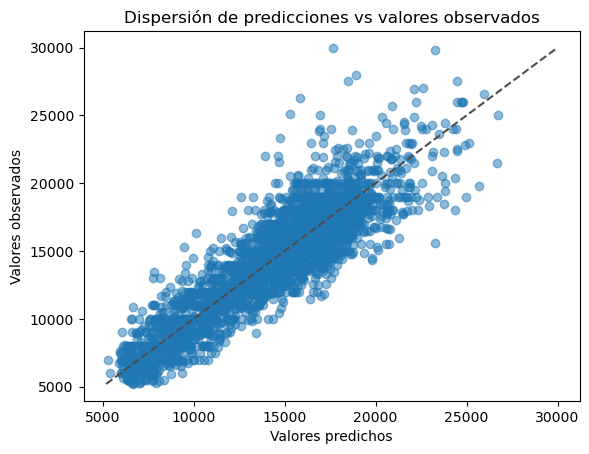

In [13]:
# Celda 2

import numpy as np

# Definir una función para generar subconjuntos aleatorios con reemplazo
n_rows = len(X_train)
Lista_indices=[]
np.random.seed(1)
Predicciones = np.empty((0, len(X_test)))
N_Trees=10
for i in range(10):
    Lista_indices.append(np.random.randint(0, n_rows, n_rows))
    X_train_bootstrapped= X_train.iloc[Lista_indices[i]]
    y_train_bootstrapped=y_train.iloc[Lista_indices[i]]
    Reg_DTree = DecisionTreeRegressor(random_state=0).fit(X_train_bootstrapped,y_train_bootstrapped)
    y_pred_ind= Reg_DTree.predict(X_test)
    Predicciones = np.concatenate((Predicciones, np.expand_dims(y_pred_ind, axis=0)), axis=0)
y_pred=Predicciones.sum(axis=0)/N_Trees

MSE_bagging_manual = np.sum(np.power(y_pred-y_test,2))/len(y_pred)
RMSE_bagging_manual = np.sqrt(MSE_bagging_manual)

mse_bagging_manual = round(mean_squared_error(y_test, y_pred),2)
r2_bagging_manual = round(r2_score(y_test, y_pred),3)
mae_bagging_manual = round(mean_absolute_error(y_test, y_pred),2)
print("Desempeño del modelo calibrado:")
print("Mean Squared Error:", mse_bagging_manual)
print("R^2 Score:", r2_bagging_manual)
print("Mean Absolute Error (MAE):", mae_bagging_manual)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_bagging_manual = round(mean_absolute_percentage_error(y_test, y_pred),2)
print("Mean Absolute Percentage Error (MAPE):", mape_bagging_manual, "%")

x_range = np.linspace(min(y_pred.min(), y_test.min()), max(y_pred.max(), y_test.max()), 1000)

fig, ax = plt.subplots()
ax.plot(x_range, x_range, ls='--', c='.3')
ax.scatter(y_pred, y_test, alpha=.5)

ax.set_xlabel('Valores predichos')
ax.set_ylabel('Valores observados')
ax.set_title('Dispersión de predicciones vs valores observados')

plt.show()


El modelo desarrollado utilizando la técnica de bagging manual con árboles de decisión tiene un error cuadrático medio (MSE)  alto, lo que sugiere que hay una  cantidad de variación en los precios de los automóviles que no se ha podido explicar con este modelo. Sin embargo, el coeficiente de determinación (R²) de 0.792 indica que el modelo es capaz de explicar el 79.2% de la variación en los precios.

El error absoluto medio (MAE) de 1333.36 indica que, en promedio, las predicciones del modelo difieren del valor real en $1333.36.

Por último, el error porcentual absoluto medio (MAPE) del 9.71% indica que, en promedio, las predicciones del modelo difieren del valor real en un 9.71% del valor real. Aunque esto no es un resultado malo, deberías considerar que en algunos casos un error del 10% puede ser significativo en términos de precios de automóviles.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

Número de caracteristicas: 2
Desempeño del modelo calibrado:
Mean Squared Error: 5543428.22
R^2 Score: 0.638
Mean Absolute Error (MAE): 1827.34
Mean Absolute Percentage Error (MAPE): 14.97 %


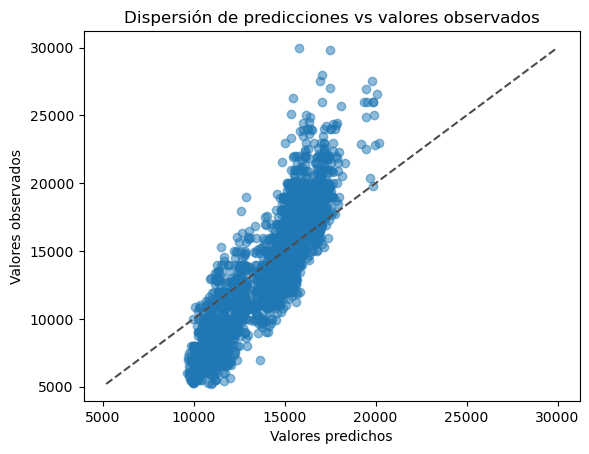

In [14]:
base_estimator = DecisionTreeRegressor(random_state=0)
bagging = BaggingRegressor(random_state=0,base_estimator=base_estimator, n_estimators=10, max_features=int(np.log(X_train.shape[1])))
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

print('Número de caracteristicas: '+str(int(np.log(X_train.shape[1]))))
MSE_bagging_sklearn = np.sum(np.power(y_pred-y_test,2))/len(y_pred)
RMSE_bagging_sklearn = np.sqrt(MSE_bagging_sklearn)

mse_bagging_sklearn = round(mean_squared_error(y_test, y_pred),2)
r2_bagging_sklearn = round(r2_score(y_test, y_pred),3)
mae_bagging_sklearn = round(mean_absolute_error(y_test, y_pred),2)
print("Desempeño del modelo calibrado:")
print("Mean Squared Error:", mse_bagging_sklearn)
print("R^2 Score:", r2_bagging_sklearn)
print("Mean Absolute Error (MAE):", mae_bagging_sklearn)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_bagging_sklearn = round(mean_absolute_percentage_error(y_test, y_pred),2)
print("Mean Absolute Percentage Error (MAPE):", mape_bagging_sklearn, "%")

x_range = np.linspace(min(y_pred.min(), y_test.min()), max(y_pred.max(), y_test.max()), 1000)

fig, ax = plt.subplots()
ax.plot(x_range, x_range, ls='--', c='.3')
ax.scatter(y_pred, y_test, alpha=.5)

ax.set_xlabel('Valores predichos')
ax.set_ylabel('Valores observados')
ax.set_title('Dispersión de predicciones vs valores observados')

plt.show()


En comparación con el primer modelo, este modelo tiene un error cuadrático medio (MSE) aún más alto, lo que sugiere que hay una cantidad significativa de variación en los precios de los automóviles que no se ha podido explicar con este modelo. Además, el coeficiente de determinación (R²) de 0.638 es más bajo que el del primer modelo, lo que indica que este modelo no es capaz de explicar tanto de la variación en los precios.

El error absoluto medio (MAE) de 1827.34 es más alto que el del primer modelo, lo que sugiere que en promedio, las predicciones del modelo difieren más del valor real. El error porcentual absoluto medio (MAPE) de 14.97% es más alto que el del primer modelo, lo que sugiere que las predicciones del modelo difieren más en términos relativos del valor real.

Es posible que el cambio en los parametros de **max_features** haya tenido un impacto en los resultados del modelo. Esta función limita el número máximo de características que se consideran en cada árbol de decisión individual utilizado en el modelo de bagging. Si bien esto puede ayudar a evitar el sobreajuste, también puede limitar la capacidad del modelo para explicar la variación en los precios de los automóviles.

**Análisis de cambio de MAPE vs cambio de max feature**

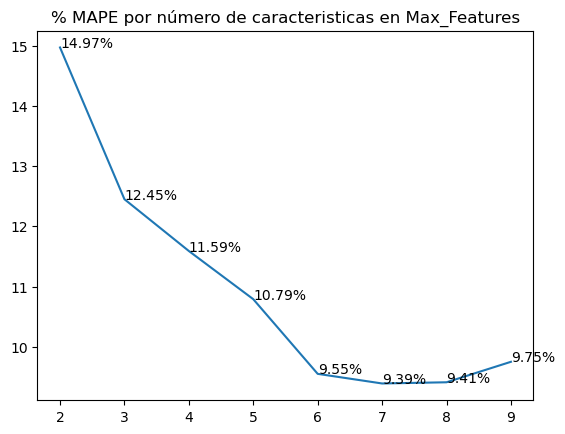

In [40]:
Lista_mapes=np.zeros(8)
j=0
features_num= np.arange(2,10)
for i in features_num:
    base_estimator = DecisionTreeRegressor(random_state=0)
    bagging = BaggingRegressor(random_state=0,base_estimator=base_estimator, n_estimators=10, max_features=i)
    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)
    mape_bagging_sklearn_list = round(mean_absolute_percentage_error(y_test, y_pred),2)
    Lista_mapes[j]=mape_bagging_sklearn_list
    j+=1
#pd.DataFrame({'Max_Features':features_num,
#              'MAPE_%':Lista_mapes})

plt.plot(features_num,Lista_mapes)
plt.title('% MAPE por número de caracteristicas en Max_Features')
for k in range(len(Lista_mapes)):
    plt.text(x=features_num[k],y=Lista_mapes[k],s=str(Lista_mapes[k])+'%')
plt.show()

El valor mínimo del MAPE se alcanza cuando Max_Features es igual a 7, lo que sugiere que agregar más características no necesariamente resulta en un mejor rendimiento. Por lo tanto, hay un punto óptimo en términos de la cantidad de características que se deben utilizar para obtener el mejor rendimiento.

También se puede observar como con pocas caracteristicas el rendimiento del modelo tiende a empeorar, esto valida nuestra hipotesis que un número bajo de caracteristicas escogidas limita la capacidad del modeo para explicar los precios de los automoviles,  y debe mantenerse en un valor de 7 (ni el mayor, ni el menor valor.).

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación  y comenten sobre el desempeño del modelo.

In [41]:
# Celda 4


# Crear un modelo de Random Forest con 100 árboles
rfc = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
rfc.fit(X_train, y_train)

# Predecir las etiquetas del conjunto de prueba
y_pred = rfc.predict(X_test)

#Desempeño modelo: 
mse_RF = round(mean_squared_error(y_test, y_pred),2)
r2_RF = round(r2_score(y_test, y_pred),3)
mae_RF = round(mean_absolute_error(y_test, y_pred),2)
print("Desempeño del modelo RF:")
print("Mean Squared Error:", mse_RF)
print("R^2 Score:", r2_RF)
print("Mean Absolute Error (MAE):", mae_RF)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_RF = round(mean_absolute_percentage_error(y_test, y_pred),2)
print("Mean Absolute Percentage Error (MAPE):", mape_RF, "%")

Desempeño del modelo RF:
Mean Squared Error: 3116678.92
R^2 Score: 0.796
Mean Absolute Error (MAE): 1314.42
Mean Absolute Percentage Error (MAPE): 9.55 %


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [42]:
# Celda 5


param_dist = {
    'n_estimators': [10, 50, 100, 200, 300, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Crear un modelo de Random Forest:
rfc = RandomForestRegressor(random_state=42)

#Realiza el Grid Search con validación cruzada. 
#RandomizedSearchCV en lugar de GridSearchCV permite  probar un número aleatorio de combinaciones de hiperparámetros en lugar de todas las posibles combinaciones
#El parámetro cv controla el número de pliegues en la validación cruzada:
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200, 300,
                                                         500]},
                   random_state=42, verbose=2)

In [43]:
#Encontrar los mejores hiperparametros: 
best_params = random_search.best_params_
print("Mejores Hiperparámetros:\n", best_params)

#Entrenar el modelo con los mejores hiperparámetros encontrados:
best_rf = random_search.best_estimator_

#Predicciones
y_pred = best_rf.predict(X_test)

#Desempeño modelo: 
mse_RF_Calibrado = round(mean_squared_error(y_test, y_pred),2)
r2_RF_Calibrado = round(r2_score(y_test, y_pred),3)
mae_RF_Calibrado = round(mean_absolute_error(y_test, y_pred),2)
print("Desempeño del modelo RF calibrado:")
print("Mean Squared Error:", mse_RF_Calibrado)
print("R^2 Score:", r2_RF_Calibrado)
print("Mean Absolute Error (MAE):", mae_RF_Calibrado)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_RF_Calibrado = round(mean_absolute_percentage_error(y_test, y_pred),2)
print("Mean Absolute Percentage Error (MAPE):", mape_RF_Calibrado, "%")

Mejores Hiperparámetros:
 {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Desempeño del modelo RF calibrado:
Mean Squared Error: 2411920.45
R^2 Score: 0.842
Mean Absolute Error (MAE): 1140.84
Mean Absolute Percentage Error (MAPE): 8.33 %


Desempeño del modelo sin calibrar Vs. el modelo calibrado: El desempeño del modelo tras la calibración de los parámetros presenta una mejora considerable:

- Mean Squared Error: Bajó de  3116678.92 a 2411920.45 


- R^2 Score: Subió de 0.796 a 0.842


- Mean Absolute Error (MAE): Bajó de 1314.42 a 1140.84


- Mean Absolute Percentage Error (MAPE): Bajó de 9.55 % a 8.33 %.

Con el modelo calibrado: nuestras predicciones se desvían de los valores reales en promedio en: $1140.84 (MAE). El porcentaje promedio de error en las predicciones en comparación con los valores reales del precio de los automóviles es de 8.33% (MAPE).

Impacto de cada parámetro sobre el desempeño del modelo: 

n_estimators: Número de árboles en el bosque aleatorio. Cuantos más árboles haya, más robusto será el modelo y mejor será su capacidad para promediar las predicciones de cada árbol individual, lo que reduce la varianza y el sobreajuste. Sin embargo, aumentar el número de árboles también puede aumentar el tiempo de entrenamiento y el costo computacional. 

max_features: Número máximo de características que se consideran para dividir un nodo en cada árbol. Un valor más pequeño de max_features puede reducir la varianza del modelo, pero puede aumentar el sesgo. Por otro lado, un valor más alto de max_features puede reducir el sesgo pero aumentar la varianza. 'auto' equivale a usar el número total de características, 'sqrt' usa  la raíz cuadrada del total de atributos.

max_depth: Es la profundidad máxima de los árboles en el bosque. Limitar la profundidad del árbol puede reducir el sobreajuste al evitar que el árbol crezca demasiado y se adapte demasiado a los datos de entrenamiento. Sin embargo, establecer una profundidad máxima demasiado baja puede resultar en un modelo demasiado simple que no captura bien la estructura de los datos y tiene un alto sesgo.

min_samples_split: Es el número mínimo de muestras necesarias para dividir un nodo interno. Un valor más alto de min_samples_split puede reducir el sobreajuste al evitar que el modelo divida nodos con pocas muestras, lo que podría llevar a un árbol demasiado complejo. Por otro lado, un valor demasiado alto puede resultar en un modelo demasiado simple con un alto sesgo.

min_samples_leaf: Es el número mínimo de muestras necesarias para que un nodo sea un nodo hoja. Un valor más alto de min_samples_leaf puede reducir el sobreajuste al evitar que el modelo genere nodos hoja con pocas muestras. Sin embargo, un valor demasiado alto puede resultar en un modelo demasiado simple que no captura bien la estructura de los datos y tiene un alto sesgo.

In [44]:
#Importancia de los predictores
importances = best_rf.feature_importances_
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importances = feature_importances.sort_values("Importance", ascending=False)
print(feature_importances)

       Feature  Importance
0         Year    0.448241
1      Mileage    0.424250
3   M_Camry4dr    0.066602
7    M_CamrySE    0.022088
8   M_CamryXLE    0.019215
6    M_CamryLE    0.007427
2      M_Camry    0.006767
4  M_CamryBase    0.002741
5     M_CamryL    0.002669


Las características con mayor importancia, las cuales contribuyen más a la capacidad del modelo para predecir el precio de venta de los automóviles son: Year, Mileage.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn y comenten sobre el desempeño del modelo.

In [46]:
!pip install xgboost==1.7.5

     --------------------------------------- 70.9/70.9 MB 18.7 MB/s eta 0:00:00


In [47]:
# Celda 6

import xgboost as xgb
from xgboost import XGBRegressor
xgb_reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, gamma=0, subsample=0.7,
                           colsample_bytree=1, max_depth=5)
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)
mse_xgboost = mean_squared_error(y_test, y_pred)
mae_xgboost = round(mean_absolute_error(y_test, y_pred),2)
r2_xgboost = round(r2_score(y_test, y_pred),3)

print("MSE: ", mse_xgboost)
print("R^2 Score:", r2_xgboost)
print("Mean Absolute Error (MAE):", mae_xgboost)
r2_xgboost = round(r2_score(y_test, y_pred),3)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_xgboost = round(mean_absolute_percentage_error(y_test, y_pred),2)
print("Mean Absolute Percentage Error (MAPE):", mape_xgboost, "%")

MSE:  2611340.3426775876
R^2 Score: 0.829
Mean Absolute Error (MAE): 1183.75
Mean Absolute Percentage Error (MAPE): 8.61 %


En general, XGBoost es una técnica de aprendizaje automático muy poderosa y flexible que a menudo produce modelos de alta precisión. Para mejorar el desempeño del modelo, se pueden ajustar los parámetros de XGBoost mediante la búsqueda de cuadrícula o la optimización bayesiana. También se pueden probar diferentes técnicas de preprocesamiento de datos y selección de características para mejorar la calidad de las variables predictoras.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [48]:
# Celda 7
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Definir el modelo de XGBoost
xgb_model = XGBRegressor()

# Definir los parámetros a calibrar y sus rangos
params = {
    "learning_rate": [0.01, 0.1, 0.5],
    "gamma": [0, 0.1, 0.5],
    "colsample_bytree": [0.5, 0.75, 1]
}

# Realizar una búsqueda exhaustiva en el espacio de hiperparámetros
grid_search = GridSearchCV(
    xgb_model,
    param_grid=params,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluar el modelo en los datos de prueba
y_pred = best_model.predict(X_test)
mse_xgboost_c = mean_squared_error(y_test, y_pred)
r2_xgboost_c = r2_score(y_test, y_pred)
mae_xgboost_c = round(mean_absolute_error(y_test, y_pred),2)
print("Mejores parámetros: ", best_params)
print("MSE en datos de prueba: ", mse_xgboost_c)
print("R^2 en datos de prueba: ", r2_xgboost_c)
print("Mean Absolute Error (MAE):", mae_xgboost_c)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_xgboost_c = round(mean_absolute_percentage_error(y_test, y_pred),2)
print("Mean Absolute Percentage Error (MAPE):", mape_xgboost_c, "%")

Mejores parámetros:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1}
MSE en datos de prueba:  2401426.5145130632
R^2 en datos de prueba:  0.8430044700264646
Mean Absolute Error (MAE): 1138.27
Mean Absolute Percentage Error (MAPE): 8.28 %


- Learning rate: Es la tasa de aprendizaje utilizada en cada iteración del algoritmo de XGBoost. Controla la magnitud de los ajustes que se realizan en los pesos de los árboles. Un valor más bajo del learning rate hace que el modelo aprenda más lentamente, lo que puede resultar en una mejor generalización y un menor sobreajuste. Por otro lado, un valor más alto del learning rate puede hacer que el modelo converja más rápidamente, pero también aumenta el riesgo de sobreajuste. Por lo tanto, es importante encontrar un valor óptimo que permita un buen equilibrio entre el rendimiento y la generalización del modelo.

- Gamma: Es el parámetro de regularización utilizado en XGBoost para controlar la complejidad del modelo y evitar el sobreajuste. Este parámetro especifica la reducción mínima en la función de pérdida que se debe obtener para que se cree un nuevo nodo en el árbol. Un valor más alto de gamma resulta en una poda más agresiva del árbol y, por lo tanto, en una reducción en la complejidad del modelo. Sin embargo, si el valor de gamma es demasiado alto, el modelo puede ser demasiado simplista y no capturar adecuadamente la complejidad de los datos.

- Colsample_bytree: Es el porcentaje de características que se deben utilizar en cada árbol. Controla la variabilidad de las características utilizadas para entrenar cada árbol y, por lo tanto, puede ayudar a reducir el sobreajuste. Un valor más bajo de colsample_bytree resulta en una menor variabilidad entre los árboles y puede ayudar a evitar el sobreajuste. Sin embargo, un valor demasiado bajo también puede hacer que el modelo pierda información importante.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

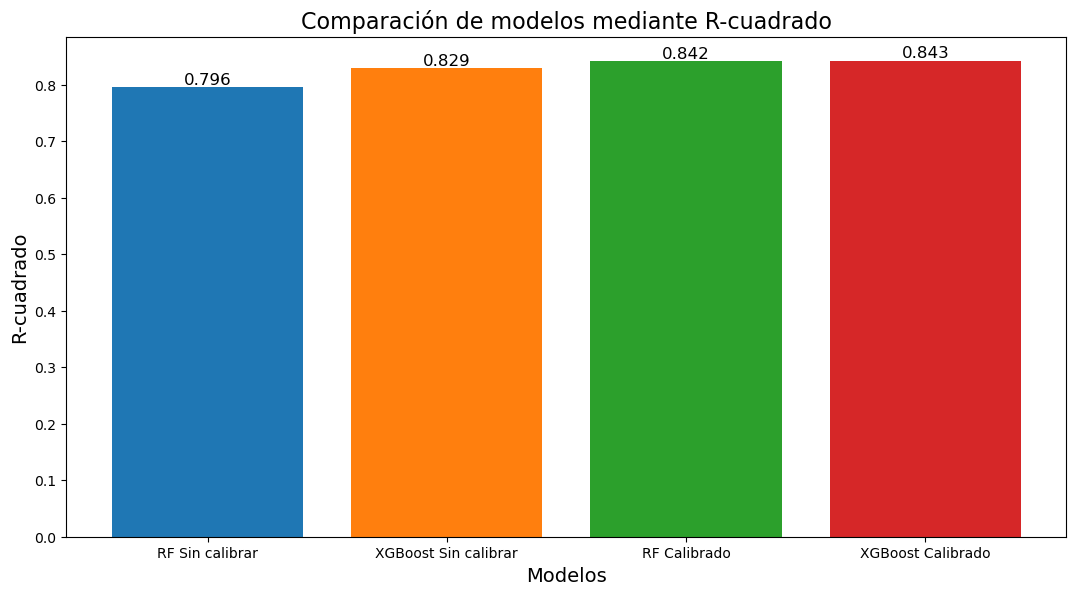

In [49]:
#Gráficar y comparar R-Cuadrado

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos mediante R-cuadrado", fontsize=16)
ax.set_xlabel("Modelos", fontsize=14)
ax.set_ylabel("R-cuadrado", fontsize=14)
ejeX = ['RF Sin calibrar', 'RF Calibrado', 'XGBoost Sin calibrar', 'XGBoost Calibrado']
ejeY = [r2_RF, r2_RF_Calibrado, r2_xgboost, r2_xgboost_c]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
ejeX, ejeY = zip(*sorted(zip(ejeX, ejeY), key=lambda x: x[1]))
ax.bar(ejeX,ejeY, color=colors)
#ax.legend(['RF Sin calibrar', 'RF Calibrado', 'XGBoost Sin calibrar', 'XGBoost Calibrado'])
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i], round(y[i],3), ha='center', va='bottom', fontsize=12)
addlabels(ejeX,ejeY,ax)
plt.show()

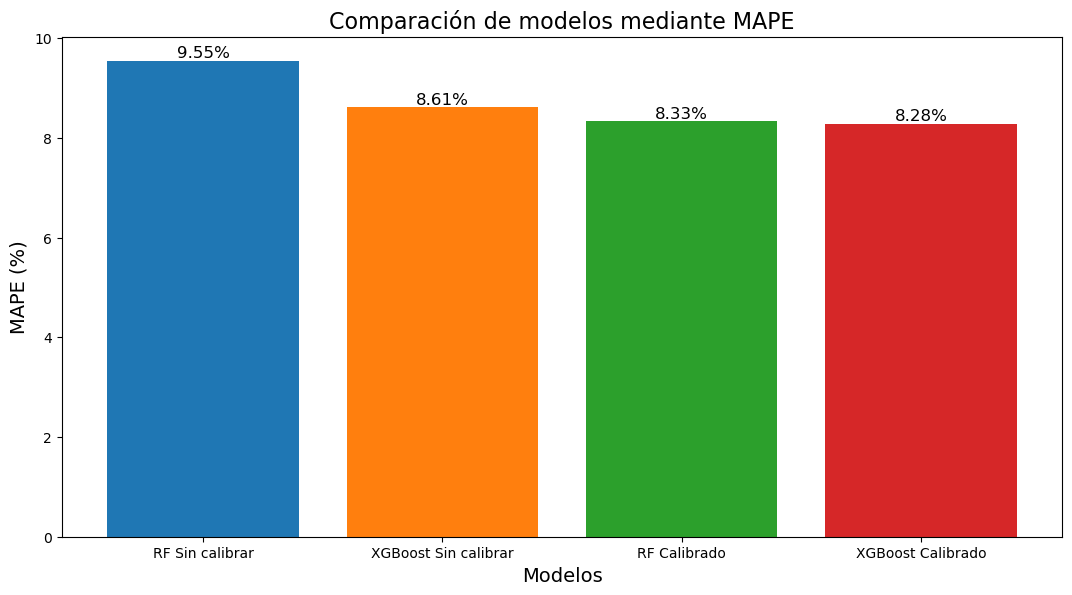

In [50]:
#Gráficar y comparar MAPE

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos mediante MAPE", fontsize=16)
ax.set_xlabel("Modelos", fontsize=14)
ax.set_ylabel("MAPE (%)", fontsize=14)
ejeX = ['RF Sin calibrar', 'RF Calibrado', 'XGBoost Sin calibrar', 'XGBoost Calibrado']
ejeY = [mape_RF, mape_RF_Calibrado, mape_xgboost, mape_xgboost_c ]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
ejeX, ejeY = zip(*sorted(zip(ejeX, ejeY), key=lambda x: x[1], reverse=True))
ax.bar(ejeX,ejeY, color=colors)
#ax.legend(['RF Sin calibrar', 'RF Calibrado', 'XGBoost Sin calibrar', 'XGBoost Calibrado'])
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i], '{:.2f}%'.format(y[i]), ha='center', va='bottom', fontsize=12)
addlabels(ejeX,ejeY,ax)
plt.show()


Se comparan dos principales métricas R-cuadrado y MAPE (Mean Absolute Percentage Error) para los modelos implementados de Random Forest y XGBoost, así mismo, según los resultados sin realizar calibración y ya calibrados para ambos. 

En cuanto al R-cuadrado, se evidencia que se comporta de una forma más equilibrada a lo largo de los modelos calibrados y no calibrados, sin embargo, es posible resaltar que el XGBoost Calibrado presenta la mejor métrica (0.84) entre los modelos, este modelo predice la variable Price con un nivel de precisión del 84%.

Sobre el MAPE, porcentaje de error absoluto medio, podemos encontrar un menor valor al implementar calibraciones en cada uno de los modelos, el modelo que presenta la mejor métrica es XGBoost Calibrado con un valor de 8.26% y nos indica que en promedio las predicciones del modelo se desvían en un 8.26% del valor real.

Características particulares del modelo XGBoost (aplicando calibración), el cual arrojó las mejores métricas, son: puede obtener una mayor precisión gracias a la combinación de varios modelos de árbol de decisión, previene el sobreajuste mediante la regularización, al realizar calibración de parámetros se puede mejorar el desempeño debido a que ayuda a encontrar los mejores valores de hiperparámetros y por ende, llevar a un mejor desempeño del modelo.

Características particulares del modelo Random Forest (sin aplicar calibración), el cuál arrojó las métricas más bajas, son: requiere una gran capacidad computacional, el modelo tiene un tiempo de entrenamiento considerable y aún más si se utiliza con un alto número de árboles o características; no es fácil determinar las variables más importantes y debido a esto difícil de interpretar; al no ajustar los parámetros de forma adecuada puede tender a sobreajustarse y no aplicarse bien a datos nuevos; por último, este tipo de modelo se ve afectado por valores atípicos y otros inconvenientes de calidad de datos.